In [2]:
!pip install torch torchvision matplotlib scikit-learn

In [48]:
import os
import torch
import shutil
import cv2
from PIL import Image, ImageDraw
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [8]:
original_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
new_path = "/kaggle/working/brain_mri"

os.makedirs(new_path, exist_ok=True)

In [9]:
# Create 'yes' and 'no' folders
for category in ['yes', 'no']:
    os.makedirs(os.path.join(new_path, category), exist_ok=True)
    src_path = os.path.join(original_path, category)
    for file in os.listdir(src_path):
        full_file_path = os.path.join(src_path, file)
        if os.path.isfile(full_file_path):
            shutil.copy(full_file_path, os.path.join(new_path, category, file))

print("Dataset copied and reorganized!")

Dataset copied and reorganized!


In [10]:
DATA_DIR = "/kaggle/working/brain_mri"
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['no', 'yes']


In [4]:
#Hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
IMG_SIZE = 224
DATA_DIR = "dataset"  # path to your dataset

In [5]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # mean
                         [0.229, 0.224, 0.225])  # std
])

In [12]:
# Set path to the reorganized dataset
DATA_DIR = "/kaggle/working/brain_mri"

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)



Classes: ['no', 'yes']


In [13]:
# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [14]:
# Load pretrained ResNet18
from torchvision import models
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [15]:
# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: 'no' and 'yes'

In [16]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    accuracy = correct.double() / len(train_set)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10, Loss: 3.2771, Accuracy: 0.7376
Epoch 2/10, Loss: 0.7527, Accuracy: 0.9752
Epoch 3/10, Loss: 0.3465, Accuracy: 0.9950
Epoch 4/10, Loss: 0.1152, Accuracy: 1.0000
Epoch 5/10, Loss: 0.1291, Accuracy: 1.0000
Epoch 6/10, Loss: 0.3195, Accuracy: 1.0000
Epoch 7/10, Loss: 0.1272, Accuracy: 0.9901
Epoch 8/10, Loss: 0.0760, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0628, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0205, Accuracy: 1.0000


In [19]:
# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.93      0.96        28
         yes       0.92      1.00      0.96        23

    accuracy                           0.96        51
   macro avg       0.96      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51



In [22]:
# Load the trained model again just to be safe
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Choose the target layer (usually the last conv layer for ResNet18)
target_layer = model.layer4[1].conv2

In [24]:
# Grad-CAM hook setup
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

In [25]:
# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [28]:
# Pick a test image
image_path = "/kaggle/working/brain_mri/yes/Y91.jpg"  # change to a real file from your dataset
img = Image.open(image_path).convert("RGB")

In [29]:
# Preprocess
preprocess = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0).to(device)

In [30]:
# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [31]:
# Backward pass for the predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

In [33]:
# Grad-CAM calculation
grads = gradients.cpu().numpy()[0]
acts = activations.detach().cpu().numpy()[0]  # <-- fixed line here

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

In [34]:
# Normalize
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= cam.min()
cam /= cam.max()

In [35]:
# Overlay on original image
img_np = np.array(img.resize((224, 224)))
heatmap = (255 * cam).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

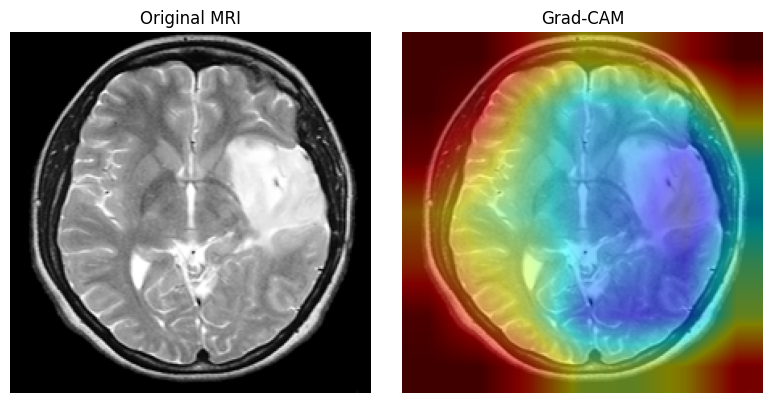

In [38]:
# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
no_images = os.listdir("/kaggle/working/brain_mri/no")
print(no_images[:5])


['no 94.jpg', '34 no.jpg', 'no 923.jpg', '27 no.jpg', 'N21.jpg']


In [40]:
# Pick a test image
image_path = "/kaggle/working/brain_mri/no/N21.jpg"  # change to a real file from your dataset
img = Image.open(image_path).convert("RGB")

In [41]:
# Preprocess
preprocess = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0).to(device)

In [42]:
# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

In [43]:
# Backward pass for the predicted class
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

In [44]:
# Grad-CAM calculation
grads = gradients.cpu().numpy()[0]
acts = activations.detach().cpu().numpy()[0]  # <-- fixed line here

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

In [45]:
# Normalize
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= cam.min()
cam /= cam.max()

In [46]:
# Overlay on original image
img_np = np.array(img.resize((224, 224)))
heatmap = (255 * cam).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

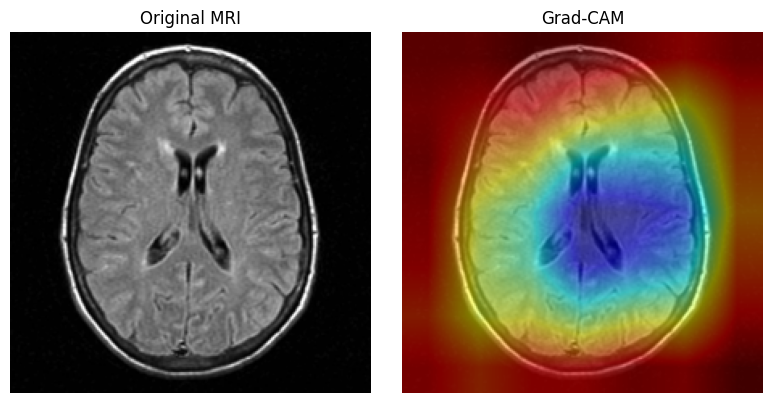

In [47]:
# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# ==== CONFIG ====
IMG_SIZE = 224
IMG_PATH = '/kaggle/input/test-image/test_img.jpg'  # change to your test image
CLASS_NAMES = ['no', 'yes']

In [53]:
# ==== TRANSFORMS ====
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [54]:
# ==== LOAD IMAGE ====
img = Image.open(IMG_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# ==== HOOKS FOR GRAD-CAM ====
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

In [57]:
# Register hooks ONLY using the old-style (compatible)
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [58]:
# ==== FORWARD + BACKWARD PASS ====
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
label = CLASS_NAMES[pred_class]

score = output[0, pred_class]
score.backward()

# ==== GRAD-CAM ====
grads = gradients.detach().cpu().numpy()[0]
acts = activations.detach().cpu().numpy()[0]

weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

✔️ No Tumor Detected


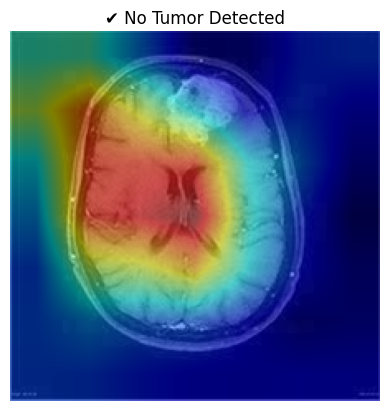

In [59]:
# ==== DRAW CIRCLE AROUND HOTTEST REGION IF TUMOR ====
original_img = img.resize((IMG_SIZE, IMG_SIZE))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed = np.array(original_img) * 0.5 + heatmap * 0.5

if label == 'yes':
    max_idx = np.unravel_index(np.argmax(cam), cam.shape)
    center = (int(max_idx[1]), int(max_idx[0]))  # (x, y)
    radius = 30

    img_with_circle = Image.fromarray(superimposed.astype(np.uint8))
    draw = ImageDraw.Draw(img_with_circle)
    draw.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius],
                 outline="red", width=3)

    plt.imshow(img_with_circle)
    plt.title("🧠 Tumor Detected")
    print("🧠 Tumor Detected")
else:
    plt.imshow(superimposed.astype(np.uint8))
    plt.title("✔️ No Tumor Detected")
    print("✔️ No Tumor Detected")

plt.axis('off')
plt.show()